# MIA attacks on Length-of-Stay predictor, Gated Recurrent Unit with Decay (GRU-D)
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from torch import zeros

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from utils.data_processing import get_mimic_dataloaders, get_mimic_dataset

The  `batch_size` is one of the parameters which is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [3]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

train_frac = 0.4
valid_frac = 0.0
test_frac = 0.0
early_stop_frac = 0.4
batch_size = 74
use_LR = False # True if you want to use the LR model, False if you want to use the GRUD model

dataset, train_indices, validation_indices, test_indices, early_stop_indices= get_mimic_dataset(path,
                                                                            train_frac ,
                                                                            valid_frac,
                                                                            test_frac,
                                                                            early_stop_frac,
                                                                            use_LR)

Loading dataset...
Loaded dataset from /home/fazeleh/LeakPro/examples/mia/LOS/data/GRUD_data/dataset.pkl


In [4]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                                                            train_indices,
                                                            validation_indices,
                                                            test_indices,
                                                            early_stop_indices,
                                                            batch_size)

The `optimized_hyperparams` is assigned based on hyperparameter tuning as detailed in [this notebook](https://github.com/MLforHealth/MIMIC_Extract/blob/4daf3c89be7de05d26f47819d68d5532de6f753a/notebooks/Baselines%20for%20Mortality%20and%20LOS%20prediction%20-%20GRU-D.ipynb).

In [5]:
optimized_hyperparams ={
    "hidden_size": 27,
    "learning_rate": 0.000289,
    "num_epochs":40,
    "patience_early_stopping": 40,
    "patience_lr_scheduler": 2,
    "batch_size": 74,
    "seed": 6286,
    "min_delta": 0.00001,
    }

n_features = int(dataset.x.shape[1]/3)
X_mean = zeros(1,dataset.x.shape[2],n_features)

# Add other required parameters to model_params
model_params = {
    "hidden_size": optimized_hyperparams["hidden_size"],
    "batch_size": optimized_hyperparams["batch_size"],
    "input_size": n_features,
    "X_mean": X_mean,
    "output_last": False,
    "bn_flag": True,
}

In [6]:
from utils.model_GRUD import *

# Initialize the model with filtered parameters
model = GRUD(**model_params)

# Train the model with Train_Model function
train_losses, test_losses , train_acc, test_acc = gru_trained_model_and_metadata(model,
                                                                                train_loader,
                                                                                early_stop_loader,
                                                                                epochs = optimized_hyperparams["num_epochs"],
                                                                                patience_early_stopping = optimized_hyperparams["patience_early_stopping"],
                                                                                patience_lr= optimized_hyperparams["patience_lr_scheduler"],
                                                                                min_delta = optimized_hyperparams["min_delta"],
                                                                                learning_rate = optimized_hyperparams["learning_rate"])

Model Structure:  GRUD(
  (zl): Linear(in_features=235, out_features=27, bias=True)
  (rl): Linear(in_features=235, out_features=27, bias=True)
  (hl): Linear(in_features=235, out_features=27, bias=True)
  (gamma_x_l): FilterLinear(in_features=104, out_features=104, bias=True)
  (gamma_h_l): Linear(in_features=104, out_features=27, bias=True)
  (fc): Linear(in_features=27, out_features=1, bias=True)
  (drop): Dropout(p=0.57, inplace=False)
  (bn): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Start Training ... 
Output type dermined by the model


Training Progress:  50%|█████     | 1/2 [00:07<00:07,  7.76s/it]

Epoch 0: Validation loss improved to 0.6235
Learning Rate: 0.000289000000
Epoch: 0, train_loss: 0.66960334, valid_loss: 0.62353804


Training Progress: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it]

Epoch 1: Validation loss improved to 0.6125
Learning Rate: 0.000289000000
Epoch: 1, train_loss: 0.63491684, valid_loss: 0.61245176


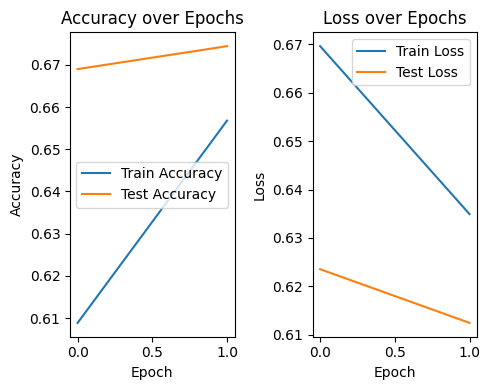

In [7]:
import matplotlib.pyplot as plt

# Convert losses to numpy-compatible lists directly
train_losses_cpu = [float(loss) for loss in train_losses]
test_losses_cpu = [float(loss) for loss in test_losses]

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

##  Attacking the GRUD model
Modify ```audit.yaml ``` file to attack GRUD model: 
  
  ```
  module_path: "utils/model_GRUD.py" 
  model_class: "GRUD"
  target_folder: "./target_GRUD"
  data_path: "./data/GRUD_data/dataset.pkl"
  ```

In [19]:
from mimic_GRUD_handler import MimicInputHandlerGRU

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandlerGRU, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

2025-02-19 14:37:26,519 INFO     Target model blueprint created from GRUD in utils/model_GRUD.py.
2025-02-19 14:37:26,556 INFO     Loaded target model metadata from ./target_GRUD/model_metadata.pkl
2025-02-19 14:37:26,562 INFO     Loaded target model from ./target_GRUD
2025-02-19 14:37:27,584 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-19 14:37:27,585 INFO     Loaded population dataset from ./data/GRUD_data/dataset.pkl
2025-02-19 14:37:27,586 INFO     MIA attack factory loaded.
2025-02-19 14:37:27,587 INFO     Configuring RMIA attack
2025-02-19 14:37:27,588 INFO     Added attack: rmia
2025-02-19 14:37:27,589 INFO     Preparing attack: rmia
2025-02-19 14:37:27,590 INFO     Preparing shadow models for RMIA attack
2025-02-19 14:37:27,591 INFO     Preparing attack data for training the RMIA attack
2025-02-19 14:37:27,593 INFO     Check for 8 shadow models (dataset: 23944 points)
2025-02-19 14:37:27,594 WARNING  Using the same model class for shadow models a

KeyboardInterrupt: 

## Report Genrating

## Report Genrating

## Report Genrating

In [ ]:

# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

2025-02-18 10:45:33,356 INFO     Initializing report handler...
2025-02-18 10:45:33,357 INFO     report_dir set to: ./leakpro_output/results
2025-02-18 10:45:33,358 INFO     Saving results for rmia


<Figure size 640x480 with 0 Axes>

In [ ]:

# # Create the report by compiling the latex text
report_handler.create_report()

2025-02-18 10:45:43,301 INFO     No results of type GIAResults found.
2025-02-18 10:45:43,302 INFO     No results of type SinglingOutResults found.
2025-02-18 10:45:43,302 INFO     No results of type InferenceResults found.
2025-02-18 10:45:43,303 INFO     No results of type LinkabilityResults found.
2025-02-18 10:45:48,543 INFO     PDF compiled


<Figure size 640x480 with 0 Axes>